## MICRO-KINETIC MODELING OF NH<sub>3</sub> DISSOCIATION AND N<sub>2</sub> AND H<sub>2</sub> FROMATION
---
### Reactions:
#### Ammonia adsorption and desorption step:
* NH<sub>3</sub> (g) + * = NH<sub>3</sub>*

#### NH<sub>3</sub> dissociation is done in 3 elementarty steps
* NH<sub>3</sub>* + * = NH<sub>2</sub>* + H*
* NH<sub>2</sub>* + * = NH* + H*
* NH* + * = N* + H*

#### N<sub>2</sub> formation is done in 3 elementarty steps
* 2 N* = NN**
* NN*** = N<sub>2</sub>* + *
* N2* = N<sub>2</sub> (g) + *

#### H<sub>2</sub> formation is done in one elementary step
* 2 H* = H<sub>2</sub> (g) + 2*

### Import functions

In [2]:
import sys
import time
import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from rate_constant_func import calc_kads as k_ads
from rate_constant_func import calc_kdes as k_des
from rate_constant_func import calc_k_arr as k_surf

from rate_constant_func import dksur_dT
from rate_constant_func import dkdes_dT

### Constants

In [3]:
    # mass of relevant reactants
m_NH3 = 17.03 * 1.66054e-27
m_N2 = 14 * 1.66054e-27
m_H2 = 2 * 1.66054e-27
m_H = 1.66054e-27

Beta = 3 #Beta  
pt = 0 # Total pressure
T0 = 50 # Initial Temperature

t_end = 400 # Time end
th_NH3_0 = 1/9
theta = 1-th_NH3_0

# Initial value
P = pt * 1e5
y0 = [P,th_NH3_0 , 0 , 0 , 0 , 0 , 0 , 0 , theta , 0 , 0 , T0]

### Define all the relevant ODEs

In this model, the initial temperature T<sub>0</sub> start at 50K, and a heating rate $\beta$ = 3 K/s. 

To simplify our current model, steady-state approximation of the following adsorbed species was used: NH<sub>2</sub><sub>ads</sub>, N-N<sub>ads</sub>, N<sub>2</sub><sub>ads</sub>, and H<sub>ads</sub>, which means:

$$\frac{\partial \theta_{NH2}}{\partial t} = 0 ; \frac{\partial \theta_{N-N}}{\partial t} = 0;  \frac{\partial \theta_{N2}}{\partial t} = 0 ; \frac{\partial \theta_{H}}{\partial t} = 0$$

In [40]:
def dydt(t,y):
    
    dydt = np.zeros(12)
    
    #  0     1       2     3      4      5      6     7     8      9     10   11
    P_NH3, Th_NH3, Th_NH2, Th_NH, Th_N, Th_NN, Th_N2, Th_H, Th,  P_N2,  P_H2, T = y 
        
    # calculate all reaction rate constants        
        #Dissociation of NH3
    k_ads_1 = k_ads(T, P_NH3, 1e-20, m_NH3)/Beta
    k_des_1 = k_des(T, 1e-20, m_NH3, 1, 8.92, 140e3)/Beta #adsorption and desorption of NH3
           
    
    k_f_2 = k_surf(T, 1e13, 110e3)/Beta
    k_b_2 = k_surf(T, 1e13,  115e3)/Beta  # dissociation of NH3
    
    k_f_3 = k_surf(T, 1e13, 35e3)/Beta
    k_b_3 = k_surf(T, 1e13, 67e3) /Beta  # dissociation of NH2
    
    k_f_4 = k_surf(T, 1e13, 118e3)/Beta
    k_b_4 = k_surf(T, 1e13,  92e3) /Beta  # dissociation of NH
    
        #formation of N2
    k_f_5 = k_surf(T, 1e13, 165e3)/Beta
    k_b_5 = k_surf(T, 1e13,  104e3)/Beta   # N-N coupling
    
    k_f_6 = k_surf(T, 1e13, 23e3)/Beta
    k_b_6 = k_surf(T, 1e13, 74e3)/Beta   #N2* formation
    
    k_des_7 = k_des(T, 1e-20, m_N2, 2, 2.88, 41.6e3)/Beta
    k_ads_7 = k_ads(T, P_N2, 1e-20, m_N2)/Beta    #N2 deorption and adsorption
    
        #formation of H2
    k_des_8 = k_des(T, 1e-20, m_H, 2, 87.6, 20e3)/Beta
    k_ads_8 = k_ads(T, P_H2, 1e-20, m_H2)/Beta
    
    # collect similar terms in new variables    
    rf1 = k_ads_1 * Th #good
    rb1 = k_des_1 * Th_NH3 ; r1 = -rb1
    
    rf2 = k_f_2 * Th_NH3 * Th #good
    rb2 = k_b_2 * Th_NH2 * Th_H ; r2 = rf2-rb2
    
    rf3 = k_f_3 * Th_NH2 * Th
    rb3 = k_b_3 * Th_NH * Th_H ; r3 = rf3-rb3
    
    rf4 = k_f_4 * Th_NH * Th
    rb4 = k_b_4 * Th_N * Th_H ; r4 = rf4-rb4
    
    rf5 = k_f_5 * Th_N**2   
    rb5 = k_b_5 * Th_NN  ; r5 = rf5-rb5
    
    rf6 = k_f_6 * Th_NN
    rb6 = k_b_6 * Th_N2*Th ; r6 = rf6-rb6
    
    rf7 = k_des_7 * Th_N2
    rb7 = k_ads_7 * Th  ; r7 = rf7-rb7
    
    rf8 = k_des_8 * Th_H**2 #good
    rb8 = k_ads_8 * Th**2  ; r8 = rf8-rb8
    
    dydt[0] = -r1  #P_NH3
    
    r8 = 0.5*(2*r2+r4)
    r7 = r5
    r6 = r5
    r3 = r2
    dydt[1] = r1 - r2          # dθ(NH3)/dt
    dydt[2] = r2 - r3 # = 0    # dθ(NH2)/dt
    dydt[3] = r3 - r4          # dθ(NH)/dt
    dydt[4] = r4 - 2*r5        # dθ(N)/dt
    dydt[5] = r5 - r6 # = 0    # dθ(N-N)/dt
    dydt[6] = r6 - r7 # = 0    # dθ(N2)/dt
    dydt[7] = r2 + r3 + r4 - 2*r8 #0  # dθ(H)/dt
    dydt[8] = r6 + r7 + 2*r8 - r1 - r2 - r3 -r4 # 2*r5-r1  # dθ(*)/dt
    
    dydt[9] = r5 #r7  # P_N2
    dydt[10] = r8 # P_H2
    
    dydt[11] = Beta   # Temperature changes with time
    
    return dydt

### Solve the ODE
Because our model is stiff, the ODEs cannot be solved using an explicit method. Consequently, **BDF method** (Backward-Differentiation Formulas) was used instead of Runge Kutta. The former however requires a **Jacobian matrix** of the right-hand side of the system with respect to y. 
Thus, a 12 x 12 Jacobian matrix has to be define first.

#### 1/ Define the Jacobian Matrix

In [5]:
def JACOB(t,x):
    
    P_NH3, Th_NH3, Th_NH2, Th_NH, Th_N, Th_NN, Th_N2, Th_H,  Th  , P_N2 , P_H2  , T   = x 
    #  0     1       2     3      4      5      6      7     8      9      10    11
    
    #Rate constants
        #desorption rate of NH3
    k1 = k_des(T, 1e-20, m_NH3, 1, 8.92, 140e3)/Beta #adsorption and desorption of NH3  
    
        #dissociation of NH3
    kf2 = k_surf(T, 1e13, 110e3)/Beta
    kb2 = k_surf(T, 1e13,  115e3)/Beta  # dissociation of NH3
    
    kf4 = k_surf(T, 1e13, 118e3)/Beta
    kb4 = k_surf(T, 1e13,  92e3) /Beta  # dissociation of NH
    
        #formation of N2
    kf5 = k_surf(T, 1e13, 165e3)/Beta
    kb5 = k_surf(T, 1e13,  104e3)/Beta   # N-N coupling
    
    kf6 = k_surf(T, 1e13, 23e3)/Beta
    kb6 = k_surf(T, 1e13, 74e3)/Beta   #N2* formation
       
    # collect similar terms in new variables    
    #             1
    r1 = - k1 * Th_NH3
    dr1_dx1 = -k1      ; dk1_dT = dkdes_dT(T, 1e-20, m_NH3, 1, 8.92, 140e3)/Beta
    dr1_dx11 = - Th_NH3* dk1_dT
    
    df0_dx1 = dr1_dx1
    df1_dx11 = dr1_dx11
    
    #           1        8          2        7
    r2 = kf2 * Th_NH3 * Th - kb2 * Th_NH2 * Th_H
    dr2_dx1= kf2 * Th
    dr2_dx2= - kb2 * Th_H
    dr2_dx7= - kb2 * Th_NH2
    dr2_dx8= kf2 * Th_NH3
    
    dkf2_dT = dksur_dT(T, 1e13, 110e3)/Beta
    dkb2_dT = dksur_dT(T, 1e13,  115e3)/Beta
    dr2_dx11= dkf2_dT * Th_NH3 * Th - dkb2_dT * Th_NH2 * Th_H
        #--------------------------
    #f1 = r1-r2
    df1_dx1 = dr1_dx1 - dr2_dx1
    df1_dx2 =       0 - dr2_dx2
    df1_dx7 =       0 - dr2_dx7
    df1_dx8 =       0 - dr2_dx8
    df1_dx11= dr1_dx11- dr2_dx11
        #--------------------------
    #f2 = 0
        #--------------------------
    #            3     8           4      7
    r4 = kf4 * Th_NH * Th - kb4 * Th_N * Th_H
    dr4_dx3 = kf4 * Th
    dr4_dx4 = - kb4 * Th_H
    dr4_dx7 = - kb4 * Th_N 
    dr4_dx8 = kf4 * Th_NH
    
    dkf4_dT = dksur_dT(T, 1e13, 118e3)/Beta
    dkb4_dT = dksur_dT(T, 1e13, 92e3)/Beta
    dr4_dx11 = dkf4_dT * Th_NH * Th - dkb4_dT * Th_N * Th_H
        #--------------------------
    #f3 = r2 - r4
    df3_dx1 = dr2_dx1 - 0
    df3_dx2 = dr2_dx2 - 0
    df3_dx3 =       0 - dr4_dx3
    df3_dx4 =       0 - dr4_dx4
    df3_dx7 = dr2_dx7 - dr4_dx7
    df3_dx8 = dr2_dx8 - dr4_dx8
    df3_dx11= dr2_dx11- dr4_dx11
        #--------------------------
    #            4               5   
    r5 = kf5 * Th_N**2 - kb5 * Th_NN
    dr5_dx4 = 2* kf5 * Th_N; df9_dx4 = dr5_dx4
    dr5_dx5 = - kb5        ; df9_dx5 = dr5_dx5
    
    dkf5_dT = dksur_dT(T, 1e13, 165e3)/Beta
    dkb5_dT = dksur_dT(T, 1e13, 104e3)/Beta
    dr5_dx11= dkf5_dT * Th_N**2 - dkb5_dT * Th_NN; df9_dx11 = dr5_dx11
        #--------------------------
    #f4= r4-2r5
    df4_dx3 = dr4_dx3 - 0
    df4_dx4 = dr4_dx4 - 2*dr5_dx4
    df4_dx5 =       0 - 2*dr5_dx5
    df4_dx7 = dr4_dx7 - 0  
    df4_dx8 = dr4_dx8 - 0
    df4_dx11= dr4_dx11- 2*dr5_dx11
        #--------------------------
    #f8 = 2r5-r1
    df8_dx1 =     0    - dr1_dx1
    df8_dx4 =2*dr5_dx4 - 0
    df8_dx5 =2*dr5_dx5 - 0
    df8_dx11=2*dr5_dx11- dr1_dx11
    
        #--------------------------
    #f10 = r2 +0.5r4
    df10_dx1 = dr2_dx1 + 0
    df10_dx2 = dr2_dx2 + 0
    df10_dx3 =    0    + 0.5*dr4_dx3
    df10_dx4 =    0    + 0.5*dr4_dx4
    df10_dx7 = dr2_dx7 + 0.5*dr4_dx7
    df10_dx8 = dr2_dx8 + 0.5*dr4_dx8
    df10_dx11= dr2_dx11+ 0.5*dr4_dx11
    
        
    # Derivatives dfi/dxi
    
    #      0       1       2         3      4        5          6       7         8       9       10   11
    #x : P_NH3, Th_NH3 , Th_NH2 , Th_NH  , Th_N   ,  Th_NN ,  Th_N2 ,   Th_H ,    Th  ,  P_N2 ,  P_H2 ,  T
    J0 = [ 0  ,df0_dx1 ,    0   ,   0    ,   0    ,   0    ,    0   ,  0     ,    0   ,  0   ,   0    , df1_dx11]
    J1 = [ 0  ,df1_dx1 ,df1_dx2 ,   0    ,   0    ,   0    ,    0   ,df1_dx7 ,df1_dx8 ,  0   ,   0    , df1_dx11]
    J2 = [ 0  ,   0    ,    0   ,   0    ,   0    ,   0    ,    0   ,   0    ,   0    ,  0   ,   0    ,  0      ] #f2 = 0
    J3 = [ 0  ,df3_dx1 ,df3_dx2 ,df3_dx3 ,df3_dx4 ,   0    ,    0   ,df3_dx7 ,df3_dx8 ,  0   ,   0    , df3_dx11]
    J4 = [ 0  ,   0    ,    0   ,df4_dx3 ,df4_dx4 ,df4_dx5 ,    0   ,df4_dx7 ,df4_dx8 ,  0   ,   0    , df4_dx11]
    J5 = [ 0  ,   0    ,    0   ,   0    ,   0    ,   0    ,    0   ,  0     ,    0   ,  0   ,   0    ,  0      ] # f5 = 0
    J6 = [ 0  ,   0    ,    0   ,   0    ,   0    ,   0    ,    0   ,   0    ,    0   ,  0   ,   0    ,  0      ] # f6 = 0
    J7 = [ 0  ,   0    ,    0   ,   0    ,   0    ,   0    ,    0   ,   0    ,    0   ,  0   ,   0    ,  0      ] #d(ThH)dt = 0
    J8 = [ 0  ,df8_dx1 ,    0   ,   0    ,df8_dx4 ,df8_dx5 ,    0   ,   0    ,    0   ,  0   ,   0    , df8_dx11]
    #f9 = r7 = r5
    J9 = [ 0  ,   0    ,    0   ,   0    ,df9_dx4 ,df9_dx5 ,    0   ,  0     ,    0   ,  0   ,   0    , df9_dx11]
    J10= [ 0  ,df10_dx1,df10_dx2,df10_dx3,df10_dx4,   0    ,    0   ,df10_dx7,df10_dx8,  0   ,   0    ,df10_dx11]
    J11= [ 0  ,   0    ,    0   ,   0    ,   0    ,   0    ,    0   ,  0     ,     0  ,  0   ,   0    ,  0      ]
    
    Jacobian = np.array([J0, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11])
    return Jacobian

#### 2/ Solve the ODEs

##### The following cell gives the wall time without the Jacobian

In [9]:
%time r0 = solve_ivp(dydt, (0,t_end), y0, method="BDF", t_eval=np.linspace(0,t_end,1000))

Wall time: 119 ms


##### The following cell gives the wall time with the Jacobian

In [10]:
%time r = solve_ivp(dydt, (0,t_end), y0, method="BDF", t_eval=np.linspace(0,t_end,1000), jac=JACOB, rtol = 1e-7, atol=1e-10)
P_NH3, Th_NH3, Th_NH2, Th_NH, Th_N, Th_NN, Th_N2, Th_H, Th, P_N2, P_H2, T = r.y 
#  0     1       2     3      4      5      6       7   8    9     10   11
t = r.t

Wall time: 273 ms


### Plot Coverage Vs Temperature

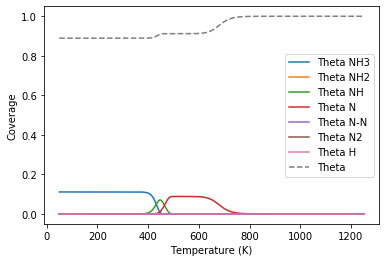

In [39]:
%matplotlib inline
plt.plot(T,Th_NH3, label= "Theta NH3")
plt.plot(T,Th_NH2, label= "Theta NH2")
plt.plot(T,Th_NH, label= "Theta NH")
plt.plot(T,Th_N, label= "Theta N")
plt.plot(T,Th_NN, label= "Theta N-N")
plt.plot(T,Th_N2, label= "Theta N2")
plt.plot(T,Th_H, label= "Theta H")
plt.plot(T,Th, label= "Theta", ls = "--")
plt.xlabel("Temperature (K)")
plt.ylabel("Coverage")
plt.legend()
plt.show()

### Plot Pressure Vs Temperature

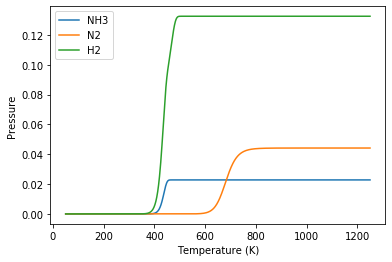

In [38]:
%matplotlib inline
plt.plot(T,P_NH3, label= "NH3")
plt.plot(T,P_N2, label= "N2")
plt.plot(T,P_H2, label= "H2")
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure")
plt.legend()
plt.show()

### Calculate Rate reaction

In [14]:
 #Rate constant
k_des_1 = k_des(T, 1e-20, m_NH3, 1, 8.92, 140e3)/Beta # NH3 desorption

k_f_2 = k_surf(T, 1e13, 110e3)/Beta # dissociation of NH3
k_b_2 = k_surf(T, 1e13,  115e3)/Beta

k_f_4 = k_surf(T, 1e13, 118e3)/Beta
k_b_4 = k_surf(T, 1e13,  92e3)/Beta   # dissociation of NH

k_f_5 = k_surf(T, 1e13, 165e3)/Beta
k_b_5 = k_surf(T, 1e13,  104e3)/Beta   # N-N coupling

        # rate calc
rb1 = k_des_1 * Th_NH3 ; r1 = rb1 #-rf1 #NH3 Ads and Des

rf2 = k_f_2 * Th_NH3 * Th 
rb2 = k_b_2 * Th_NH2 * Th_H ; r2 = rf2-rb2 # NH3* rate

rf4 = k_f_4 * Th_NH * Th
rb4 = k_b_4 * Th_N * Th_H ; r4 = rf4-rb4 # NH* rate

rf5 = k_f_5 * Th_N**2   
rb5 = k_b_5 * Th_NN  ; r5 = rf5-rb5 # N* rate

r7 = r5 # N2 Des desorption

r8 = 0.5*(2*r2+r4)# H2 Des desorption

### Plot TPD of NH<sub>3</sub>

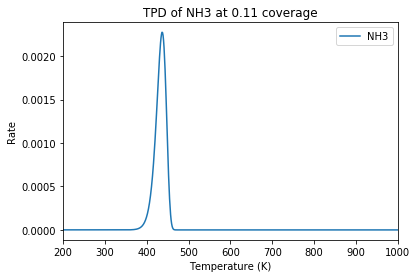

In [29]:
%matplotlib inline
plt.plot(T,r1, label= "NH3")
plt.title("TPD of NH3 at "+ str(round(th_NH3_0,2))+" coverage")
plt.xlabel("Temperature (K)")
plt.ylabel("Rate")
plt.legend()
plt.xlim(200,1000)
plt.show()

### Plot TPD of N<sub>2</sub>

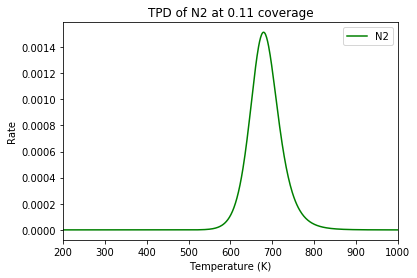

In [35]:
%matplotlib inline
plt.plot(T,r7, label= "N2", color ="g")
plt.title("TPD of N2 at "+ str(round(th_NH3_0,2))+" coverage")
plt.xlabel("Temperature (K)")
plt.ylabel("Rate")
plt.legend()
plt.xlim(200,1000)
plt.show()

### Plot TPD of H<sub>2</sub>

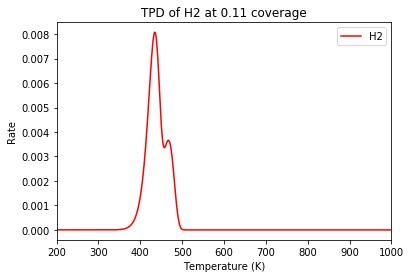

In [36]:
%matplotlib inline
plt.plot(T,r8, label= "H2", color ="r")
plt.title("TPD of H2 at "+ str(round(th_NH3_0,2))+" coverage")
plt.xlabel("Temperature (K)")
plt.ylabel("Rate")
plt.legend()
plt.xlim(200,1000)
plt.show()